In [1]:
!python -m pip install chess

/home/calum/anaconda3/lib/python3.8/site-packages/secretstorage/__init__.py:10: UserWarning: jeepney.integrate.blocking is deprecated: please use jeepney.io.blocking instead.
  from jeepney.integrate.blocking import DBusConnection, connect_and_authenticate


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from aruco import *
from label import *

In [3]:
import os
import tempfile
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torchvision.io import read_image, write_jpeg

In [46]:
data_dir = tempfile.mkdtemp(prefix="chess-vision-")
data_dir

'/tmp/chess-vision-cabrf55d'

In [52]:
%%timeit
adams = Game("Adams", 0)
img = next(adams.images)["color"]

1.15 ms ± 47.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
%%timeit
adams = Game("Adams", 0)
img = list(adams.images)[0]["color"]

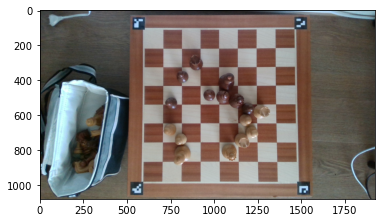

In [48]:
img = img[:,:,[2,1,0]] # BGR -> RGB
img = np.moveaxis(img, -1, 0) # (1080, 1920, 3) -> (3, 1080, 1920)
plt.imshow(img)

In [50]:
write_jpeg(torch.tensor(img), os.path.join(data_dir, "img.jpg"))

In [ ]:
class ChessPiecesDataset(Dataset):
    def __init__(self, games, games_dir='games', transform=None):
        data_dir = tempfile.mkdtemp(prefix="chess-vision-")
        for game in games:
            for img, lbl in label(game):
                
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [6]:
data_transform = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

data_dir = 'data/pieces'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
class LeNet(nn.Module):
    def __init__(self, channels, classes):
        super(LeNet, self).__init__()
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=20, kernel_size=(5, 5))
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5))

        self.fc1 = nn.Linear(in_features=800, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=classes)
        self.logSoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = self.maxpool(self.relu(self.conv1(x)))
        x = self.maxpool(self.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1())
        x = self.fc2(x)

        return self.logSoftmax(x)